In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [58]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [4]:
def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    # Load training batches
    for i in range(1, 6):
        batch = unpickle(f"{data_dir}/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']

    train_data = np.concatenate(train_data, axis=0)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, H, W, C)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"{data_dir}/test_batch")
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])

    return (train_data, train_labels), (test_data, test_labels)


In [111]:


class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = self.data[idx]
        image = Image.fromarray(self.data[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Load data
(data_dir) = '/kaggle/input/cifar10-python/cifar-10-batches-py'
(train_data, train_labels), (test_data, test_labels) = load_cifar10_data(data_dir)


In [112]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),#usng this for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=test_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [99]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(4608,512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.conv_layer(x)
        return x

In [100]:
model = CNN().to(device)

In [101]:
import torch.optim as optim

In [102]:
optimizer = optim.SGD(model.parameters(),lr=1e-02)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [103]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 2.1431478766089285


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x373248 and 4608x512)

In [ ]:
(torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum()

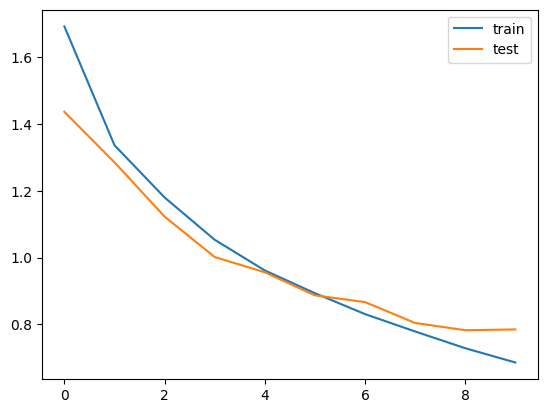

In [32]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


Alexnet

In [104]:
from torchvision.models import alexnet

In [105]:
alex = alexnet(pretrained=True)

In [106]:
alex.classifier[6] = nn.Linear(4096,10) #Changing this as the out_features for alexnet is 1000

In [107]:
alex = alex.to(device)

In [108]:
#hyperparameters
alex_optim = optim.SGD(alex.parameters(),lr = 1e-03)
epochs = 5

In [113]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = alex(x)
        loss = loss_fn(pred,y)
        loss.backward()
        alex_optim.step()
        alex_optim.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = alex(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 0.812550063201501
Test_loss 0.6125154553796537 | Accuracy 0.7858
Epoch: 1 | Train loss: 0.5381268871112733
Test_loss 0.5080711938226565 | Accuracy 0.8232
Epoch: 2 | Train loss: 0.4634279708830272
Test_loss 0.46217511846615483 | Accuracy 0.838
Epoch: 3 | Train loss: 0.4131842792005548
Test_loss 0.4256678289308335 | Accuracy 0.8505
Epoch: 4 | Train loss: 0.3814634545989244
Test_loss 0.41562998468597856 | Accuracy 0.8567


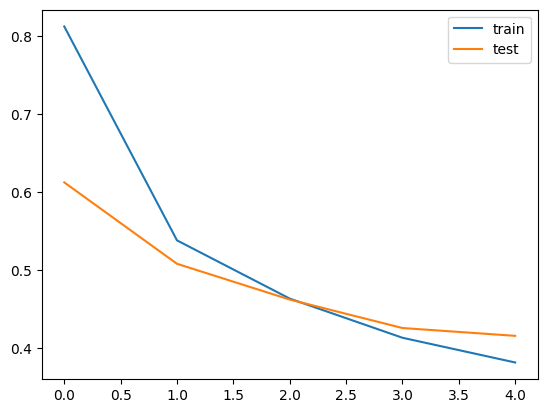

In [114]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


RESNET 

In [115]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),#usng this for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=test_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [119]:
from torchvision import models

In [146]:
resnetmodel = models.resnet50(pretrained=True)

In [147]:
for param in resnetmodel.parameters():
    param.requires_grad = False

In [148]:
resnetmodel.fc.in_features

2048

In [149]:
#modify the FCN
input_tolinear = resnetmodel.fc.in_features
resnetmodel.fc = nn.Linear(in_features=input_tolinear,out_features = 10)
resnetmodel = resnetmodel.to(device)

In [150]:
#hyperparam
resnet_optim = optim.SGD(resnetmodel.parameters(),lr=1e-02)
epochs = 10

In [151]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = resnetmodel(x)
        loss = loss_fn(pred,y)
        loss.backward()
        resnet_optim.step()
        resnet_optim.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = resnetmodel(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 0.8652582159617431
Test_loss 0.6735294468867512 | Accuracy 0.7779
Epoch: 1 | Train loss: 0.6474314883532466
Test_loss 0.639905055014851 | Accuracy 0.7848
Epoch: 2 | Train loss: 0.6092087751920606
Test_loss 0.6329672890730178 | Accuracy 0.7812
Epoch: 3 | Train loss: 0.5912175353471087
Test_loss 0.5936977464836627 | Accuracy 0.7965
Epoch: 4 | Train loss: 0.5748817556021081
Test_loss 0.5847957937386089 | Accuracy 0.7997
Epoch: 5 | Train loss: 0.5685369020765284
Test_loss 0.5726166387049916 | Accuracy 0.8029
Epoch: 6 | Train loss: 0.559004608343903
Test_loss 0.5705124501127024 | Accuracy 0.8063
Epoch: 7 | Train loss: 0.5512546319002077
Test_loss 0.5900957917157834 | Accuracy 0.794
Epoch: 8 | Train loss: 0.5473398163542866
Test_loss 0.5677767515944215 | Accuracy 0.8046


KeyboardInterrupt: 

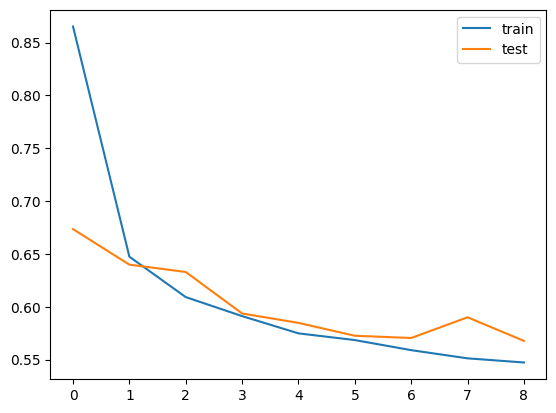

In [152]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()